In [1]:
import sympy
import matplotlib.pyplot as plt
import numpy as np

sympy.init_printing()

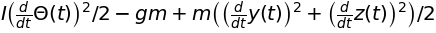

In [2]:
# create our functions for y, z and Θ against time, t
t = sympy.symbols('t')
y = sympy.Function('y')(t)
z = sympy.Function('z')(t)
Θ = sympy.Function('Θ')(t)

# constants: length from CoM to rotor, mass, inertia, gravity, force from left rotor, force from right rotor
l, m, I, g, F1, F2 = sympy.symbols('l m I g F1 F2')

# velocity of the drone is made up of velocity in y and z directions
v = sympy.sqrt(y.diff(t)**2 + z.diff(t)**2)

# kinetic energy of the drone subtract potential energy
L = sympy.Rational(1, 2)*(m*v**2 + I*Θ.diff(t)**2) - m*g

# print out the Lagrangian
L

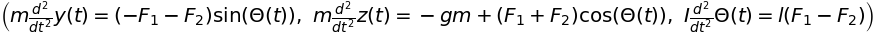

In [3]:
# euler equations
euler1 = L.diff(y.diff(t)).diff(t) - L.diff(y)
euler2 = L.diff(z.diff(t)).diff(t) - L.diff(z)
euler3 = L.diff(Θ.diff(t)).diff(t) - L.diff(Θ)

# create the equations, first arg is LHS, second is RHS
eq1 = sympy.Eq(euler1, -(F1 + F2)*sympy.sin(Θ))
eq2 = sympy.Eq(euler2, (F1 + F2)*sympy.cos(Θ) - m*g)
eq3 = sympy.Eq(euler3, (F1-F2)*l)

# print out the equations
eq1, eq2, eq3

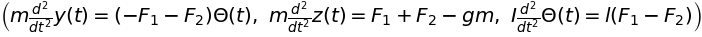

In [4]:
# linearize our system for hover
# sin(Θ) = Θ, cos(Θ) = 1, (d/dt(Θ))**2 = 0
linearize = [(sympy.sin(Θ), Θ), (sympy.cos(Θ), 1), (Θ.diff(t)**2, 0)]
eq1_lin = eq1.subs(linearize)
eq2_lin = eq2.subs(linearize)
eq3_lin = eq3.subs(linearize)

# print out the linearized equations
eq1_lin, eq2_lin, eq3_lin

In [5]:
# solve our linear system for linear and angular accelerations
eq_of_mot = sympy.linsolve([eq1_lin, eq2_lin, eq3_lin], [y.diff(t, t), z.diff(t, t), Θ.diff(t, t)])

eq_of_mot

#### State Space Representation

*NOTE: linearized equations for hover*

$x(t) =
\begin{bmatrix}
x_1 \\
x_2 \\
x_3 \\
x_4 \\
x_5 \\
x_6 \\
\end{bmatrix} = 
\begin{bmatrix}
y \\
z \\
\theta \\
\dot{y} \\
\dot{z} \\
\dot{\theta} \\
\end{bmatrix}$

$\dot{x(t)} =
\begin{bmatrix}
\dot{x_1} \\
\dot{x_2} \\
\dot{x_3} \\
\dot{x_4} \\
\dot{x_5} \\
\dot{x_6} \\
\end{bmatrix} = 
\begin{bmatrix}
x_4 \\
x_5 \\
x_6 \\
\ddot{y} \\
\ddot{z} \\
\ddot{\theta} \\
\end{bmatrix} = 
\begin{bmatrix} 
\dot{y} \\
\dot{z} \\
\dot{\theta} \\
\dfrac{-u_1\theta}{m} \\
\dfrac{u_1}{m} - g \\
\dfrac{u_2}{I}
\end{bmatrix}= 
\begin{bmatrix} 
x_4 \\
x_5 \\
x_6 \\
\dfrac{-u_1x_3}{m} \\
\dfrac{u_1}{m} - g \\
\dfrac{u_2}{I}
\end{bmatrix}$

where:

$u = 
\begin{bmatrix}
u_1 \\
u_2
\end{bmatrix} = 
\begin{bmatrix}
F_1 + F_2 \\
l(F_1 - F_2)
\end{bmatrix}$

In [6]:
# define our ivp function using our state space representation
def quadcopter(t, y, F1, F2, constants):
    u1 = F1 + F2
    u2 = constants['l'] * (F1 - F2)
    x1dot = y[3]
    x2dot = y[4]
    x3dot = y[5]
    x4dot = (-u1 * y[2]) / constants['m']
    x5dot = (u1 / constants['m']) - constants['g']
    x6dot = u2 / constants['I']
    return [x1dot, x2dot, x3dot, x4dot, x5dot, x6dot]

In [7]:
from scipy.integrate import solve_ivp

y0 = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

F1, F2 = 0.0, 0.0
constants = dict(
    l = 0.15,  # 15 cm from CoM to rotor
    m = 0.2,   # 200 g
    I = 0.001, # kg*m^2
    g = 9.81   # gravity, m/s^2
)
args = (F1, F2, constants)
sol = solve_ivp(quadcopter, [0, 10], y0, args=args, dense_output=True)

In [8]:
def plot_all(title, t, z):
    plt.figure(figsize=(20, 12))

    plt.subplot(2, 3, 1)
    plt.plot(t, z.T[:,0], 'r')
    plt.xlabel('time (s)')
    plt.ylabel('Y position (m)')
    plt.title(title)
    plt.grid(True)

    plt.subplot(2, 3, 2)
    plt.plot(t, z.T[:,1], 'b')
    plt.xlabel('time (s)')
    plt.ylabel('Z position (m)')
    plt.grid(True)

    plt.subplot(2, 3, 3)
    plt.plot(t, z.T[:,2], 'g')
    plt.xlabel('time (s)')
    plt.ylabel('Θ angle (radians)')
    plt.grid(True)

    plt.subplot(2, 3, 4)
    plt.plot(t, z.T[:,3], 'y')
    plt.xlabel('time (s)')
    plt.ylabel('Y velocity (m/s)')
    plt.grid(True)

    plt.subplot(2, 3, 5)
    plt.plot(t, z.T[:,4], 'm')
    plt.xlabel('time (s)')
    plt.ylabel('Z velocity (m/s)')
    plt.grid(True)

    plt.subplot(2, 3, 6)
    plt.plot(t, z.T[:,5], 'c')
    plt.xlabel('time (s)')
    plt.ylabel('Θ angular velocity (radians/s)')
    plt.grid(True)

    plt.xlabel('time (s)')
    plt.show()

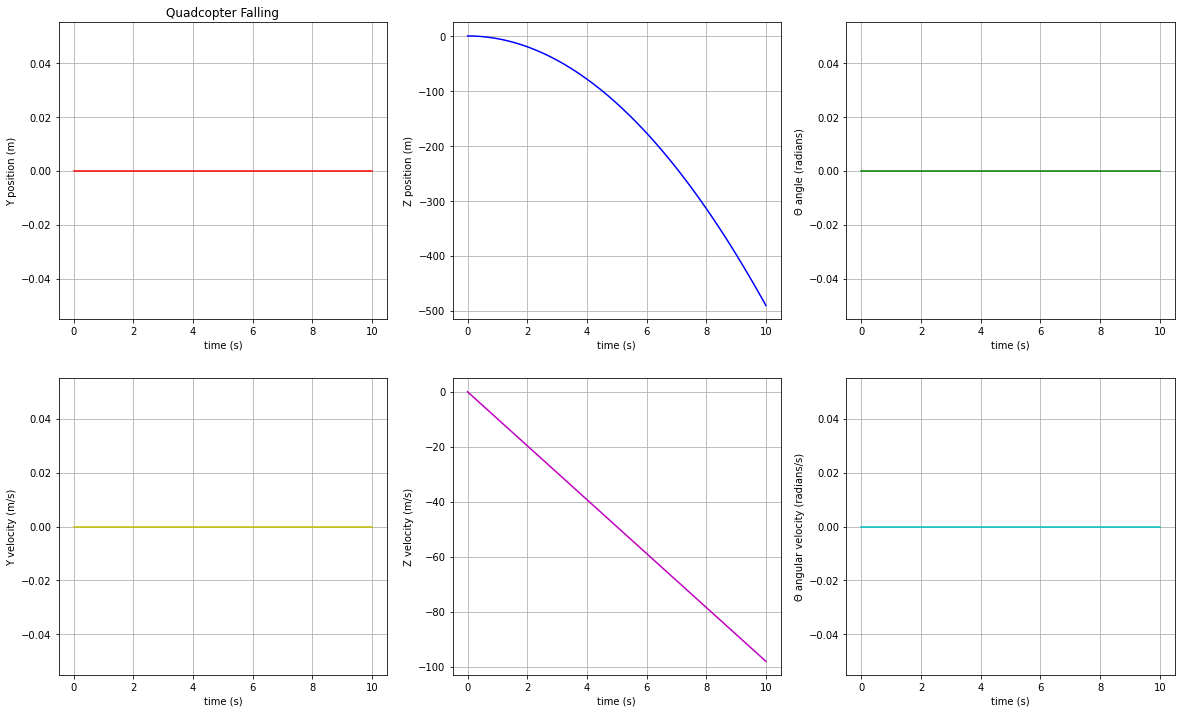

In [9]:
t = np.linspace(0, 10, 100)
z = sol.sol(t)

# we expect the quadcopter to fall from the sky, z decreasing exponentially, and zdot (velocity) increasing linearly, all other states should be 0
plot_all('Quadcopter Falling', t, z)

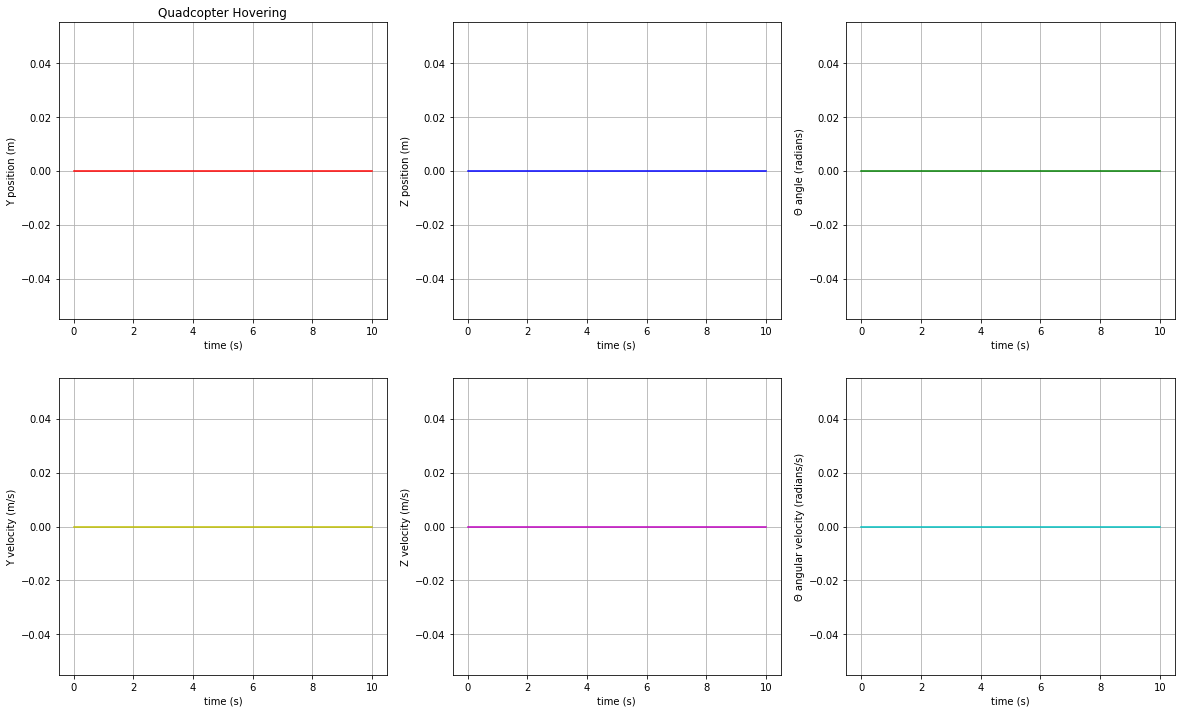

In [10]:
# each rotor will exert half of the exact force to keep it level
hover_force = constants['g'] * constants['m'] / 2

# F1, F2, l, m, I, g
args = (hover_force, hover_force, constants)
sol = solve_ivp(quadcopter, [0, 10], y0, args=args, dense_output=True)

t = np.linspace(0, 10, 100)
z = sol.sol(t)

# we expect all states to be 0 in this case, as the quadcopter is hovering at its start position
plot_all('Quadcopter Hovering', t, z)

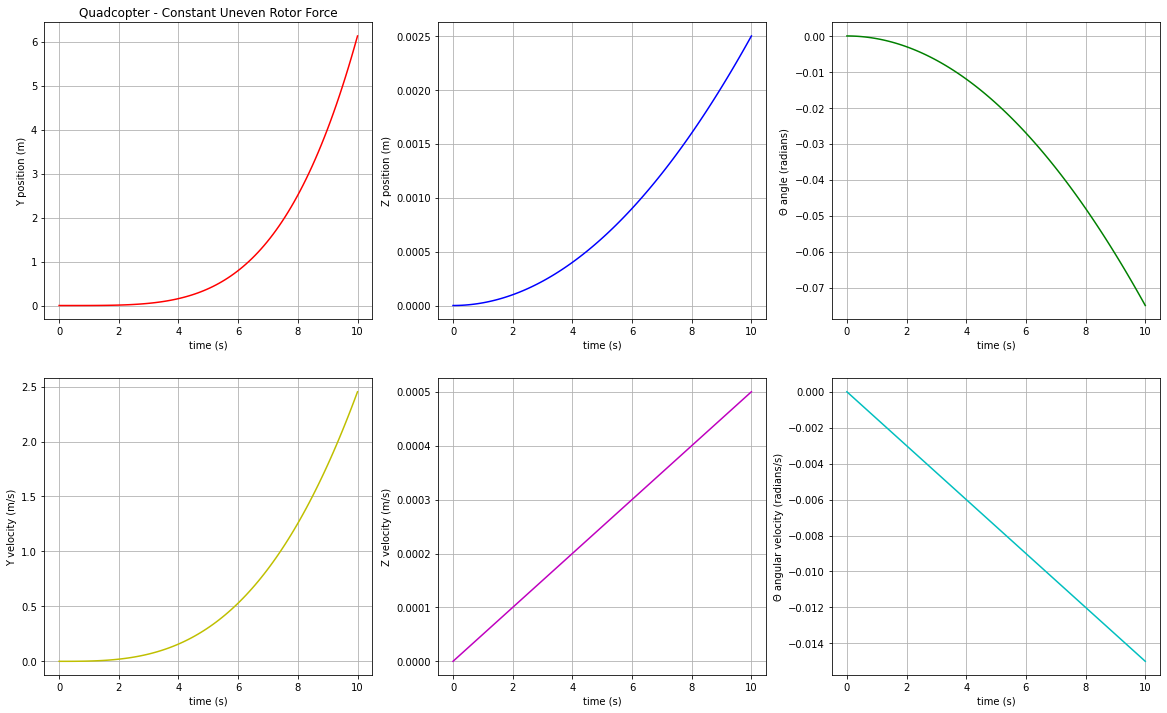

In [11]:
# set F2 to slightly more
# F1, F2, l, m, I, g
args = (hover_force, hover_force+0.00001, constants)
sol = solve_ivp(quadcopter, [0, 10], y0, args=args, dense_output=True)

t = np.linspace(0, 10, 100)
z = sol.sol(t)

# in this case, we expect the quadcopter to to start moving in the y direction, gain some height, and start rotating CW
plot_all('Quadcopter - Constant Uneven Rotor Force', t, z)

#### Controller Equations - PD
Design a controller that hover's the quadcopter at a given position. In this case, the desired accellerations and velocities will be zero at steady state.

We will ignore any error at this point - we assume that the quadcopter will not be placed under windy conditions

In [12]:
# to compute the required forces, we will have 2 equations and 2 unknowns, F1, and F2
# We can put the queation into form Af = u, where x is a 2x1 vector containing F1 and F2, and b is a 2x1 vector containing u1 and u2
# TODO: put this in the above markdown
# we will be able to solve for our forces, f, by inverting A and multiplying it by the calculated values for u

# define our ivp function using the control equations, and pass in our controller PD variables for each state
# pd objects are tuple where element 0 is proportional, and element 1 is derivative
# ref is a 2 element tuple represent y, z
def quadcopter_pid(t, y, constants, pdy, pdz, pdΘ, ref):
    u1 = constants['m']*(constants['g'] - y[4]*pdz[1] + (ref[1] - y[1])*pdz[0])
    Θc = (-1 / constants['g']) * (-pdy[1]*y[3] + (ref[0] - y[0])*pdy[0])
    u2 = -pdΘ[1]*y[5] + pdΘ[0]*(Θc - y[2])
    x1dot = y[3]
    x2dot = y[4]
    x3dot = y[5]
    x4dot = (-u1 * y[2]) / constants['m']
    x5dot = (u1 / constants['m']) - constants['g']
    x6dot = u2 / constants['I']
    return [x1dot, x2dot, x3dot, x4dot, x5dot, x6dot]

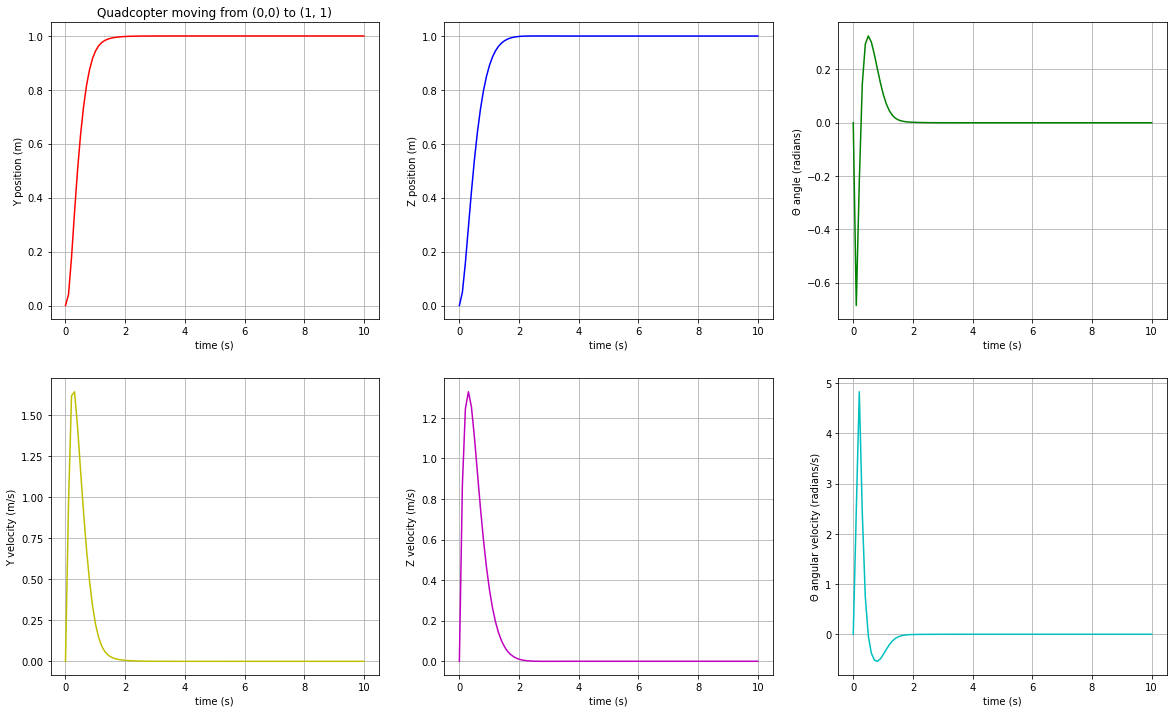

In [17]:
# PD gains for y, z, and Θ and finally the reference point
pdy, pdz, pdΘ, ref = (12, 6.5), (12, 6.5), (50, 3), (1, 1)
args = (constants, pdy, pdz, pdΘ, ref)
sol = solve_ivp(quadcopter_pid, [0, 10], y0, args=args, dense_output=True)

t = np.linspace(0, 10, 100)
z = sol.sol(t)

# in this case we expect the PD controllers to move the quad copter to the reference point
plot_all(f'Quadcopter moving from (0,0) to {ref}', t, z)